In [1]:
# !pip list -v

In [2]:
import talib as ta
import joblib
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import yfinance as yahoo_finance

/home/mskolnik/.virtualenvs/stock_price_predictor/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#suppress 'SettingWithCopy' warning
pd.set_option('mode.chained_assignment', None)

In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

In [6]:
# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False) 

In [7]:
#optional 
#yahoo_finance.pdr_override()

In [8]:
%matplotlib inline

In [9]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [10]:
# ___variables___
#ticker = 'TSLA'
#ticker = 'AAPL'
#ticker = 'NFLX'
#ticker = 'MSFT'
#ticker = 'NFLX'
#ticker = 'GOOGL'
#ticker = 'AMZN'
ticker = 'MOS'
#ticker = 'TLT'
#ticker = 'IBM'
#ticker = 'F'
#ticker = 'C'
#ticker = 'PG'
#ticker = 'JNJ'
# ticker = 'SWK' # Stanley Black & Decker
# ticker = "PPIACO" # PPI

start_time = datetime.datetime(1900, 1, 1)
#end_time = datetime.datetime(2019, 1, 20)
end_time = datetime.datetime.now().date().isoformat()         # today

In [11]:
def get_data(ticker):
    # yahoo gives only daily historical data
    connected = False
    while not connected:
        try:
            df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
            connected = True
            print('connected to yahoo')
        except Exception as e:
            print("type error: " + str(e))
            time.sleep( 5 )
            pass   

    # use numerical integer index instead of date    
    df = df.reset_index()
    #print(df.head(5))
    return df

In [12]:
df = get_data(ticker)

connected to yahoo


In [13]:
# df.head()

In [14]:
df = df.sort_values(by="Date")

In [15]:
df.head()

Date     High      Low     Open    Close     Volume  Adj Close
0 1988-01-26  11.7500  11.2500  11.5000  11.5000  7244600.0   7.283533
1 1988-01-27  12.3750  11.4375  11.5625  12.3750  3652400.0   7.837721
2 1988-01-28  12.5625  12.1250  12.2500  12.5625  2180000.0   7.956467
3 1988-01-29  12.5625  11.8750  12.4375  12.2500  1335400.0   7.758548
4 1988-02-01  12.2500  11.9375  12.1250  12.0000   488800.0   7.600207

### Compute various stock technical indicators
For each stock we compute several technical indicators, we use mainly exponential moving averages, Bollinger Bands, RSI and so on. We will then feed these into neural network as features (or values derived from these indicators).

In [16]:
def compute_technical_indicators(df):
    # df['EMA5'] = ta.EMA(df['Adj Close'].values, timeperiod=5)
    # df['EMA10'] = ta.EMA(df['Adj Close'].values, timeperiod=10)
    # df['EMA15'] = ta.EMA(df['Adj Close'].values, timeperiod=15)
    # df['EMA20'] = ta.EMA(df['Adj Close'].values, timeperiod=10)
    # df['EMA30'] = ta.EMA(df['Adj Close'].values, timeperiod=30)
    # df['EMA40'] = ta.EMA(df['Adj Close'].values, timeperiod=40)
    df['SMA50'] = ta.SMA(df['Adj Close'].values, timeperiod=50)

    # df['EMA60'] = ta.EMA(df['Adj Close'].values, timeperiod=60)
    # df['EMA70'] = ta.EMA(df['Adj Close'].values, timeperiod=70)
    # df['EMA80'] = ta.EMA(df['Adj Close'].values, timeperiod=80)
    # df['EMA90'] = ta.EMA(df['Adj Close'].values, timeperiod=90)
    
    df['SMA100'] = ta.SMA(df['Adj Close'].values, timeperiod=100)
    df['SMA150'] = ta.SMA(df['Adj Close'].values, timeperiod=150)
    df['SMA200'] = ta.SMA(df['Adj Close'].values, timeperiod=200)

    df['upperBB'], df['middleBB'], df['lowerBB'] = ta.BBANDS(df['Adj Close'].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

    df['SAR'] = ta.SAR(df['High'].values, df['Low'].values, acceleration=0.02, maximum=0.2)

    # we will normalize RSI
    df['RSI'] = ta.RSI(df['Adj Close'].values, timeperiod=14)

    df['normRSI'] = ta.RSI(df['Adj Close'].values, timeperiod=14) / 100.0

    # My new additions
    df["LR100Day"] = ta.LINEARREG(df['Adj Close'].values, timeperiod=100)
    df["LR150Day"] = ta.LINEARREG(df['Adj Close'].values, timeperiod=150)
    df["LR200Day"] = ta.LINEARREG(df['Adj Close'].values, timeperiod=200)

#     df["CDL3LINESTRIKE"] = ta.CDL3LINESTRIKE(df["Open"].values, df["High"].values, df["Low"].values, df['Adj Close'].values)
#     df["CDL3WHITESOLDIERS"] = ta.CDL3WHITESOLDIERS(df["Open"].values, df["High"].values, df["Low"].values, df['Adj Close'].values)
#     df["CDLENGULFING"] = ta.CDLENGULFING(df["Open"].values, df["High"].values, df["Low"].values, df['Adj Close'].values)
#     df["CDLHAMMER"] = ta.CDLHAMMER(df["Open"].values, df["High"].values, df["Low"].values, df['Adj Close'].values)
#     df["CDLINVERTEDHAMMER"] = ta.CDLINVERTEDHAMMER(df["Open"].values, df["High"].values, df["Low"].values, df['Adj Close'].values)
#     df["CDLMORNINGSTAR"] = ta.CDLMORNINGSTAR(df["Open"].values, df["High"].values, df["Low"].values, df['Adj Close'].values)
#     df["CDLMORNINGDOJISTAR"] = ta.CDLMORNINGDOJISTAR(df["Open"].values, df["High"].values, df["Low"].values, df['Adj Close'].values)
#     df["CDLPIERCINGLINE"] = ta.CDLPIERCING(df["Open"].values, df["High"].values, df["Low"].values, df['Adj Close'].values)
#     df["CDLSPINNINGTOP"] = ta.CDLSPINNINGTOP(df["Open"].values, df["High"].values, df["Low"].values, df['Adj Close'].values)

    df.tail()

    return df

In [17]:
df = compute_technical_indicators(df)

In [18]:
df.tail()

Date       High        Low       Open      Close     Volume  Adj Close      SMA50     SMA100     SMA150     SMA200    upperBB  middleBB    lowerBB        SAR        RSI   normRSI   LR100Day   LR150Day   LR200Day
8749 2022-10-13  52.310001  48.900002  49.689999  52.000000  3895900.0  52.000000  53.280417  52.220883  56.681679  53.709578  55.174979  50.83000  46.485021  48.189999  51.257152  0.512572  51.560648  47.341292  55.672660
8750 2022-10-14  52.070000  46.660000  52.070000  46.860001  8387700.0  46.860001  53.186122  52.082536  56.583345  53.745511  55.185822  50.56300  45.940177  53.279999  40.090183  0.400902  51.518874  47.147695  55.396329
8751 2022-10-17  48.580002  47.250000  47.970001  48.250000  4739500.0  48.250000  53.109454  51.985948  56.519617  53.792117  54.508937  50.23200  45.955063  53.147599  43.664547  0.436645  51.484374  46.944026  55.139072
8752 2022-10-18  51.099998  49.060001  49.189999  50.810001  5050700.0  50.810001  53.082191  51.898841  56.470766  53.851126  53.918410  50.05700  46.195590  53.017847  49.625576  0.496256  51.588729  46.814855  54.932036
8753 2022-10-19  51.759998  50.310001  50.680000  50.695000  1571187.0  50.695000  53.018717  51.819142  56.426853  53.905092  53.458270  49.91675  46.375230  52.890690  49.372835  0.493728  51.676613  46.673180  54.729891

In [19]:
def compute_features(df):
    # computes features for forest decisions
    # df['aboveEMA5'] = np.where(df['Adj Close'] > df['EMA5'], 1, 0)
    # df['aboveEMA10'] = np.where(df['Adj Close'] > df['EMA10'], 1, 0)
    # df['aboveEMA15'] = np.where(df['Adj Close'] > df['EMA15'], 1, 0)
    # df['aboveEMA20'] = np.where(df['Adj Close'] > df['EMA20'], 1, 0)
    # df['aboveEMA30'] = np.where(df['Adj Close'] > df['EMA30'], 1, 0)
    # df['aboveEMA40'] = np.where(df['Adj Close'] > df['EMA40'], 1, 0)
    
    df['aboveSMA50'] = np.where(df['Adj Close'] > df['SMA50'], 1, 0)
    # df['aboveEMA60'] = np.where(df['Adj Close'] > df['EMA60'], 1, 0)
    # df['aboveEMA70'] = np.where(df['Adj Close'] > df['EMA70'], 1, 0)
    # df['aboveEMA80'] = np.where(df['Adj Close'] > df['EMA80'], 1, 0)
    # df['aboveEMA90'] = np.where(df['Adj Close'] > df['EMA90'], 1, 0)
    
    # df['aboveSMA100'] = np.where(df['Adj Close'] > df['SMA100'], 1, 0)
    # df['aboveSMA150'] = np.where(df['Adj Close'] > df['SMA150'], 1, 0)
    df['aboveSMA200'] = np.where(df['Adj Close'] > df['SMA200'], 1, 0)

    df['aboveUpperBB'] = np.where(df['Adj Close'] > df['upperBB'], 1, 0)
    df['belowLowerBB'] = np.where(df['Adj Close'] < df['lowerBB'], 1, 0)
    
    df['aboveSAR'] = np.where(df['Adj Close'] > df['SAR'], 1, 0)
   
    df['oversoldRSI'] = np.where(df['RSI'] < 30, 1, 0)
    df['overboughtRSI'] = np.where(df['RSI'] > 70, 1, 0)

    # My new additions
    df['upTrendMA'] = np.where(df['SMA100'] > df['SMA200'], 1, 0)
    df['upTrendLR'] = np.where(df['LR100Day'] > df['LR200Day'], 1, 0)

    # very important - cleanup NaN values, otherwise prediction does not work
    df=df.fillna(0).copy()
    
    df.tail()

    return df

In [20]:
df = compute_features(df)

In [21]:
df.tail()

Date       High        Low       Open      Close     Volume  Adj Close      SMA50     SMA100     SMA150  ...   LR200Day  aboveSMA50  aboveSMA200  aboveUpperBB  belowLowerBB  aboveSAR  oversoldRSI  overboughtRSI  upTrendMA  upTrendLR
8749 2022-10-13  52.310001  48.900002  49.689999  52.000000  3895900.0  52.000000  53.280417  52.220883  56.681679  ...  55.672660           0            0             0             0         1            0              0          0          0
8750 2022-10-14  52.070000  46.660000  52.070000  46.860001  8387700.0  46.860001  53.186122  52.082536  56.583345  ...  55.396329           0            0             0             0         0            0              0          0          0
8751 2022-10-17  48.580002  47.250000  47.970001  48.250000  4739500.0  48.250000  53.109454  51.985948  56.519617  ...  55.139072           0            0             0             0         0            0              0          0          0
8752 2022-10-18  51.099998  49.060001  49.189999  50.810001  5050700.0  50.810001  53.082191  51.898841  56.470766  ...  54.932036           0            0             0             0         0            0              0          0          0
8753 2022-10-19  51.759998  50.310001  50.680000  50.695000  1571187.0  50.695000  53.018717  51.819142  56.426853  ...  54.729891           0            0             0             0         0            0              0          0          0

[5 rows x 29 columns]

In [22]:
def plot_train_data(df):
    # plot price
    plt.figure(figsize=(15,2.5))
    plt.title("Stock data " + str(ticker))
    plt.plot(df["Date"], df["Adj Close"])
    # plt.title('Price chart (Adj Close) ' + str(ticker))
    plt.show()
    return None

In [23]:
def define_target_condition(df):
    # price higher later - bad predictive results
    # df["target_cls"] = np.where(df["Adj Close"].shift(-34) > df["Adj Close"], 1, 0)
    
    # price above trend multiple days later
    df["target_cls"] = np.where(df["Adj Close"].shift(-55) > df["LR150Day"].shift(-55), 1, 0)
    
    # important - remove NaN values
    df = df.fillna(0).copy()
    
    df.tail()
    
    return df

In [24]:
df = define_target_condition(df)

In [25]:
df.tail()

Date       High        Low       Open      Close     Volume  Adj Close      SMA50     SMA100     SMA150  ...  aboveSMA50  aboveSMA200  aboveUpperBB  belowLowerBB  aboveSAR  oversoldRSI  overboughtRSI  upTrendMA  upTrendLR  target_cls
8749 2022-10-13  52.310001  48.900002  49.689999  52.000000  3895900.0  52.000000  53.280417  52.220883  56.681679  ...           0            0             0             0         1            0              0          0          0           0
8750 2022-10-14  52.070000  46.660000  52.070000  46.860001  8387700.0  46.860001  53.186122  52.082536  56.583345  ...           0            0             0             0         0            0              0          0          0           0
8751 2022-10-17  48.580002  47.250000  47.970001  48.250000  4739500.0  48.250000  53.109454  51.985948  56.519617  ...           0            0             0             0         0            0              0          0          0           0
8752 2022-10-18  51.099998  49.060001  49.189999  50.810001  5050700.0  50.810001  53.082191  51.898841  56.470766  ...           0            0             0             0         0            0              0          0          0           0
8753 2022-10-19  51.759998  50.310001  50.680000  50.695000  1571187.0  50.695000  53.018717  51.819142  56.426853  ...           0            0             0             0         0            0              0          0          0           0

[5 rows x 30 columns]

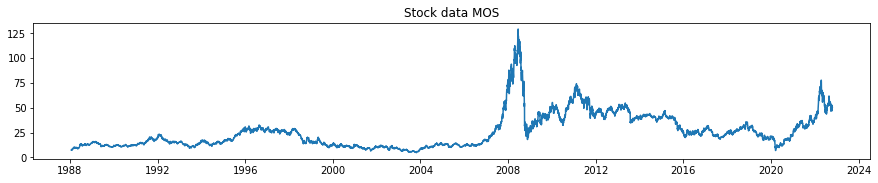

In [26]:
plot_train_data(df)

## Train-Test split and Training part
You can set the 'warm_start' parameter to True in the model. This will ensure the retention of learned parameters from previous round using .fit method.

In [27]:
# predictors_list = ['aboveSAR','aboveUpperBB','belowLowerBB','normRSI','oversoldRSI','overboughtRSI',
#                    'aboveEMA5','aboveEMA10','aboveEMA15','aboveEMA20','aboveEMA30','aboveEMA40',
#                    'aboveEMA50','aboveEMA60','aboveEMA70','aboveEMA80','aboveEMA90','aboveEMA100']
predictors_list = ['aboveSAR','aboveUpperBB','belowLowerBB','normRSI','oversoldRSI','overboughtRSI',
                   'aboveSMA50', 'aboveSMA200', "upTrendLR", "upTrendMA",]

In [28]:
def splitting_and_training(df, predictors_list, test_size=0.3):
    # __predictors__
    
    # __features__
    X = df[predictors_list].fillna(0)
    X.tail()
    
    # __targets__
    y_cls = df.target_cls.fillna(0)
    y_cls.tail(10)
    
    # __train test split__
    from sklearn.model_selection import train_test_split
    y = y_cls
    X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    
#     print ("X_cls_train.shape:", X_cls_train.shape)
#     print ("y_cls_train.shape:", y_cls_train.shape)
#     print ("X_cls_test.shape:", X_cls_test.shape)
#     print ("y_cls_test.shape:", y_cls_test.shape)
    
    # __ RANDOM FOREST __ - retrainable - warm_start
    from sklearn.ensemble import RandomForestClassifier
    
    # Create a Gaussian Classifier - incremental training - warm_start=True
    clf=RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=20, min_samples_leaf=10, 
                               n_jobs=-1, warm_start=True)
    
    # __ACTUAL TRAINING __
    clf = clf.fit(X_cls_train, y_cls_train)
    clf

    # __ making accuracy report __
    # ideally should be getting better with each round
    y_cls_pred = clf.predict(X_cls_test)

    from sklearn.metrics import classification_report
    report = classification_report(y_cls_test, y_cls_pred)
    print(report)

    return clf

In [29]:
# get trained classifier
clf = splitting_and_training(df, predictors_list)

              precision    recall  f1-score   support

           0       0.62      0.62      0.62      1270
           1       0.65      0.65      0.65      1357

    accuracy                           0.64      2627
   macro avg       0.64      0.64      0.64      2627
weighted avg       0.64      0.64      0.64      2627



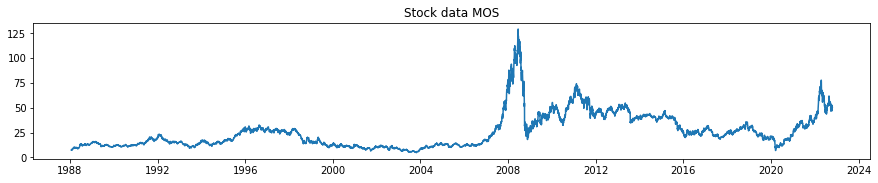

In [30]:
plot_train_data(df)

In [31]:
df

Date       High        Low       Open      Close     Volume  Adj Close      SMA50     SMA100     SMA150  ...  aboveSMA50  aboveSMA200  aboveUpperBB  belowLowerBB  aboveSAR  oversoldRSI  overboughtRSI  upTrendMA  upTrendLR  target_cls
0    1988-01-26  11.750000  11.250000  11.500000  11.500000  7244600.0   7.283533   0.000000   0.000000   0.000000  ...           0            0             0             0         0            0              0          0          0           1
1    1988-01-27  12.375000  11.437500  11.562500  12.375000  3652400.0   7.837721   0.000000   0.000000   0.000000  ...           0            0             0             0         0            0              0          0          0           1
2    1988-01-28  12.562500  12.125000  12.250000  12.562500  2180000.0   7.956467   0.000000   0.000000   0.000000  ...           0            0             0             0         0            0              0          0          0           1
3    1988-01-29  12.562500  11.875000  12.437500  12.250000  1335400.0   7.758548   0.000000   0.000000   0.000000  ...           0            0             0             0         0            0              0          0          0           1
4    1988-02-01  12.250000  11.937500  12.125000  12.000000   488800.0   7.600207   0.000000   0.000000   0.000000  ...           0            0             0             0         0            0              0          0          0           1
...         ...        ...        ...        ...        ...        ...        ...        ...        ...        ...  ...         ...          ...           ...           ...       ...          ...            ...        ...        ...         ...
8749 2022-10-13  52.310001  48.900002  49.689999  52.000000  3895900.0  52.000000  53.280417  52.220883  56.681679  ...           0            0             0             0         1            0              0          0          0           0
8750 2022-10-14  52.070000  46.660000  52.070000  46.860001  8387700.0  46.860001  53.186122  52.082536  56.583345  ...           0            0             0             0         0            0              0          0          0           0
8751 2022-10-17  48.580002  47.250000  47.970001  48.250000  4739500.0  48.250000  53.109454  51.985948  56.519617  ...           0            0             0             0         0            0              0          0          0           0
8752 2022-10-18  51.099998  49.060001  49.189999  50.810001  5050700.0  50.810001  53.082191  51.898841  56.470766  ...           0            0             0             0         0            0              0          0          0           0
8753 2022-10-19  51.759998  50.310001  50.680000  50.695000  1571187.0  50.695000  53.018717  51.819142  56.426853  ...           0            0             0             0         0            0              0          0          0           0

[8754 rows x 30 columns]

In [44]:
def predict_timeseries(df, clf):
    
    # making sure we have good dimensions
    # column will be rewritten later
    df['Buy'] = df['target_cls']
    
    for i in range(len(df)):
        for i in range(len(df)):
            X_cls_valid = [[df['aboveSAR'][i],df['aboveUpperBB'][i],df['belowLowerBB'][i],
                            df['normRSI'][i],df['oversoldRSI'][i],df['overboughtRSI'][i],
                            df['aboveSMA50'][i],df['aboveSMA200'][i],df['upTrendLR'][i],
                            df['upTrendMA'][i]]]

        y_cls_pred_valid = clf.predict(X_cls_valid)
        df['Buy'][i] = y_cls_pred_valid[0].copy()

    print(df.head())    
        
    return df

In [33]:
def plot_stock_prediction(df, ticker):
    # plot  values and significant levels
    plt.figure(figsize=(30,7))
    plt.title('Predictive model ' + str(ticker))
    plt.plot(df['Date'], df['Adj Close'], label='Adj Close', alpha=0.2)

    plt.plot(df['Date'], df['SMA50'], label='SMA50', alpha=0.2)
    plt.plot(df['Date'], df['SMA100'], label='SMA100', alpha=0.2)
    plt.plot(df['Date'], df['SMA150'], label='SMA150', alpha=0.2)
    plt.plot(df['Date'], df['SMA200'], label='SMA200', alpha=0.2)
    plt.plot(df['Date'], df['upTrendLR'], label='Up Trend LR', alpha=0.2)
    plt.plot(df['Date'], df['upTrendMA'], label='Up Trend MA', alpha=0.2)


    plt.scatter(df['Date'], df['Buy']*df['Adj Close'], label='Buy', marker='^', color='magenta', alpha=0.15)
    #lt.scatter(df.index, df['sell_sig'], label='Sell', marker='v')

    plt.legend()

    plt.show()

    return None  

In [34]:
def save_model(clf):
    import joblib

    joblib.dump(clf, "./random_forest.joblib")

    return None

### Training Sequence

In [35]:
tickers = ['F', 'IBM', 'GE', 'AAPL', 'ADM', "C", "TLT", "AAP", "ORLY", "EPD",
           'XOM', 'GM','MMM','KO','PEP','SO','GS',
          'HAS','PEAK','HPE','HLT','HD','HON','HRL','HST','HPQ','HUM','ILMN', 
          'INTC','ICE','INTU','ISRG','IVZ','IRM','JNJ','JPM','JNPR','K','KMB', 
          'KIM', 'KMI','KSS','KHC', 'KR',
          'LEG', 'LIN', 'LMT','LOW',
          'MAR', 'MA','MCD','MDT', 'MRK',
          'MET', 'MGM', 'MU','MSFT', 'MAA',
          "SBK", "PG",
          'MNST', 'MCO','MS', 'MSI', 
          'MMM', 'ABT','ACN','ATVI','ADBE','AMD','A','AKAM','ARE','GOOG','AMZN','AAL',
#         from more_tickers
          "GLD", "SLV", "SILJ", "SIL", "GDX", "GDXJ", "FNV", "NEM", "RGLD", "GOLD",
          "PSLV",]

In [36]:
# parent dataframe to append to
ticker = "SPY"
df = get_data(ticker)
df = compute_technical_indicators(df)
df = compute_features(df)
df = define_target_condition(df)

connected to yahoo


In [37]:
for ticker in tickers:
    t_df = get_data(ticker)
    t_df = compute_technical_indicators(t_df)
    t_df = compute_features(t_df)
    t_df = define_target_condition(t_df)
    
    df = pd.concat([df, t_df], ignore_index=True)
    clf = splitting_and_training(df, predictors_list)
    
    save_model(clf)
    # commenting out saves time during training
    #df = predict_timeseries(df, clf)
    #plot_stock_prediction(df, ticker)

connected to yahoo
              precision    recall  f1-score   support

           0       0.67      0.63      0.65      2918
           1       0.67      0.71      0.69      3140

    accuracy                           0.67      6058
   macro avg       0.67      0.67      0.67      6058
weighted avg       0.67      0.67      0.67      6058

connected to yahoo
              precision    recall  f1-score   support

           0       0.67      0.64      0.65      5149
           1       0.68      0.71      0.69      5501

    accuracy                           0.67     10650
   macro avg       0.67      0.67      0.67     10650
weighted avg       0.67      0.67      0.67     10650

connected to yahoo
              precision    recall  f1-score   support

           0       0.67      0.63      0.65      7404
           1       0.67      0.71      0.69      7838

    accuracy                           0.67     15242
   macro avg       0.67      0.67      0.67     15242
weighted avg     

In [38]:
df.tail()

Date    High    Low  Open  Close     Volume  Adj Close   SMA50  SMA100    SMA150  ...  aboveSMA50  aboveSMA200  aboveUpperBB  belowLowerBB  aboveSAR  oversoldRSI  overboughtRSI  upTrendMA  upTrendLR  target_cls
763381 2022-10-13  6.6200  6.440  6.48   6.57  5294100.0       6.57  6.7174  6.8613  7.363133  ...           0            0             0             0         0            0              0          0          1           0
763382 2022-10-14  6.5100  6.330  6.50   6.36  4987400.0       6.36  6.7062  6.8503  7.345467  ...           0            0             0             0         0            0              0          0          1           0
763383 2022-10-17  6.5600  6.450  6.53   6.47  6682900.0       6.47  6.6992  6.8393  7.330267  ...           0            0             0             0         0            0              0          0          1           0
763384 2022-10-18  6.5700  6.440  6.56   6.49  3880000.0       6.49  6.6872  6.8285  7.315467  ...           0            0             0             0         0            0              0          0          1           0
763385 2022-10-19  6.4296  6.375  6.40   6.41  2864205.0       6.41  6.6746  6.8171  7.299667  ...           0            0             0             0         0            0              0          0          1           0

[5 rows x 30 columns]

In [39]:
df.shape

(763386, 30)

## Prediction
Here the model will perform trend predictions on an unknown dataset (has not seen it during training or testing).

In [40]:
ticker = 'SWN'

In [41]:
# load classifier, no need to initialize the loaded_rf
loaded_clf = joblib.load("./random_forest.joblib")
clf = loaded_clf

In [42]:
new_df = get_data(ticker)

connected to yahoo


In [45]:
new_df = compute_technical_indicators(new_df)
new_df = compute_features(new_df)
new_df = define_target_condition(new_df)
new_df = predict_timeseries(new_df, clf)

        Date      High       Low  Open     Close    Volume  Adj Close  SMA50  SMA100  SMA150  ...  aboveSMA200  aboveUpperBB  belowLowerBB  aboveSAR  oversoldRSI  overboughtRSI  upTrendMA  upTrendLR  target_cls  Buy
0 1980-03-17  0.739583  0.718750   0.0  0.718750  220800.0   0.536853    0.0     0.0     0.0  ...            0             0             0         0            0              0          0          0           1    1
1 1980-03-18  0.687500  0.666667   0.0  0.666667  398400.0   0.497951    0.0     0.0     0.0  ...            0             0             0         0            0              0          0          0           1    1
2 1980-03-19  0.708333  0.687500   0.0  0.687500  379200.0   0.513512    0.0     0.0     0.0  ...            0             0             0         0            0              0          0          0           1    1
3 1980-03-20  0.708333  0.687500   0.0  0.687500   72000.0   0.513512    0.0     0.0     0.0  ...            0             0            

Below plots are showing predictions on unseen dataset. When the triangle overlay is on the price data, it means buy. When the triangle is on the zero level, it means, don't buy. This model is pretty much giving only long signals, but can be extrapolated to sell signals as well.

So the Buy signal means, that the model thinks that in n days (here 55 days) the price will be above specific Exponencial Moving Average (here was trained to be above 150 EMA in 55 days).

We see that the model is giving some false positive signals (of course it is), but not that many actually. It just sometimes expects trend reversal too early, but if we are using this as an investing advisor for long term hold or long term swing trades, the signals provided by the model are very nice.

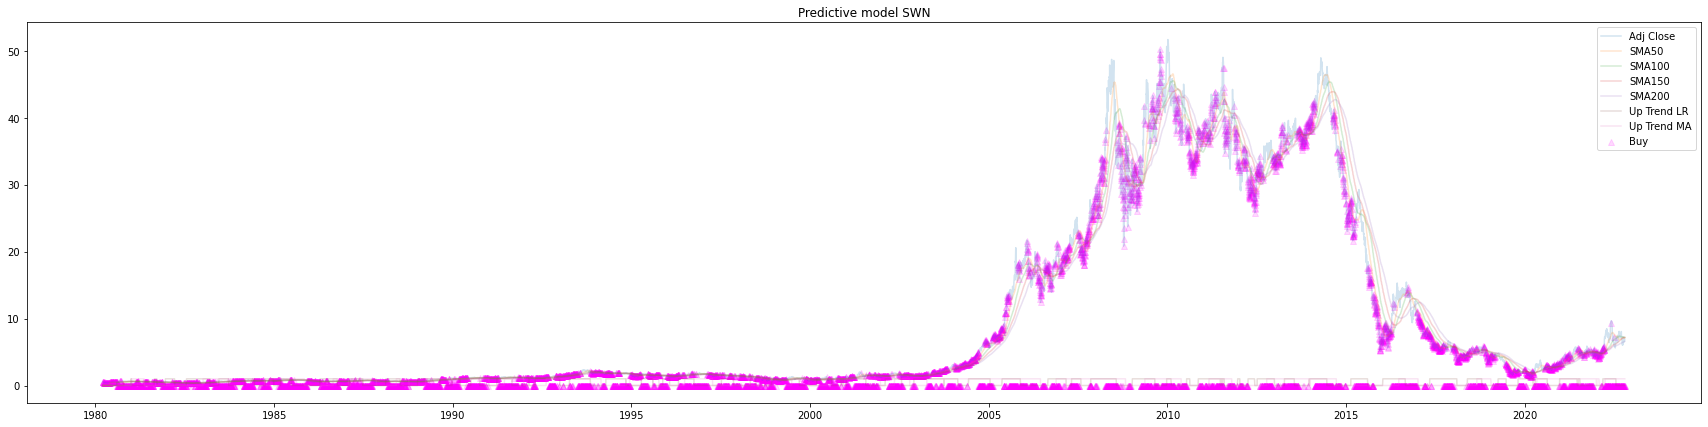

In [46]:
plot_stock_prediction(new_df, ticker)

In [47]:
# zoom in on the data
temp_df = new_df[-700:]

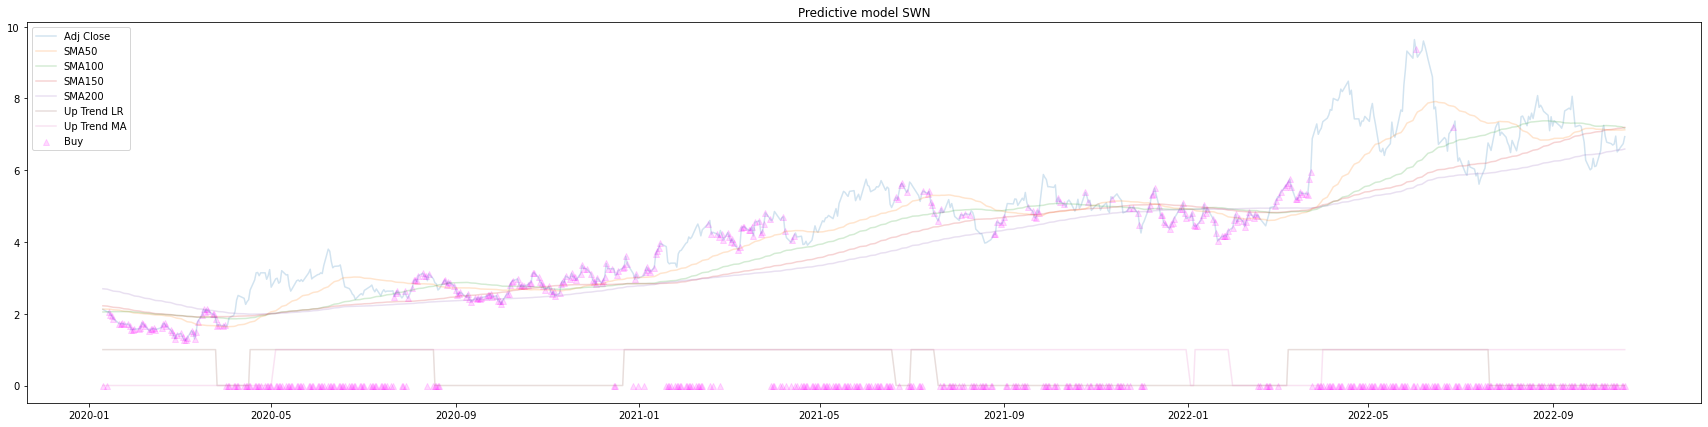

In [48]:
plot_stock_prediction(temp_df, ticker)